In [239]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
import requests


In [216]:
# Dynamic stock data fetched from wikipedia list of S&P 500 companies

def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    
    # The relevant table containing S&P 500 information is typically the first one
    sp500_table = df_list[0]
    
    # Extracting the columns of interest
    sp500_data = sp500_table[['Symbol', 'Security']]
    
    return sp500_data

# Call the function to get the S&P 500 data
sp500_data = get_sp500_tickers()
companies_dict = sp500_data.set_index('Symbol').to_dict()['Security']

# Display the data
print(len(companies_dict))
tickers = list(companies_dict.keys())



503


In [217]:
# Reading data from the given csv file

data = pd.read_csv('SP500_prices.csv')

In [218]:
# Data cleaning - removing columns with company names not in S&P 500

for c in data.columns[1:]:
    if c not in tickers:
        data = data.drop([c], axis=1)

# Data cleaning - datatype conversion and date filtering

data.date = pd.to_datetime(data.date)
data = data[data.date > "2018"][data.date < "2022"]
data.index = data["date"]
data.drop(columns=["date"],inplace=True)        

In [219]:
data.head()

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667


In [220]:
returns_1_day = data.pct_change()
# returns_2_day = data.pct_change(2)
# returns_5_day = data.pct_change(5)
# returns_10_day = data.pct_change(10)
# returns_20_day = data.pct_change(20)
# returns_60_day = data.pct_change(60)
# returns_252_day = data.pct_change(252)



# Removing the first row of NaN values due to pct_change function

returns_1_day = returns_1_day.iloc[1:,:]





# list_of_returns = [returns_1_day,returns_2_day,returns_5_day,returns_10_day,returns_20_day,returns_60_day,returns_252_day]

In [221]:
# we can only work with stocks that have the full return series

# for returns in list_of_returns:
#     returns.dropna(axis=1,inplace=True)
#     returns = returns_1_day.iloc[1:,:]

# list_of_returns

In [222]:
# Checking for NaN values

# Check for missing values in returns_1_day
missing_values = returns_1_day.isnull().sum()

# Display columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]
print("Columns with Missing Values:")
print(columns_with_missing_values)

# Display total number of missing values in each column
print("\nTotal Number of Missing Values in Each Column:")
print(missing_values)

# Print missing vlues in csv file

# missing_values.to_csv('missing.csv')



# As we can see, there are columns with missing values, we will drop them

returns_1_day.dropna(axis=1,inplace=True)


Columns with Missing Values:
CARR     556
CDAY      79
CEG     1007
CTVA     350
DOW      304
FOX      299
FOXA     298
MRNA     235
OTIS     556
dtype: int64

Total Number of Missing Values in Each Column:
A       0
AAL     0
AAPL    0
ABBV    0
ABT     0
       ..
YUM     0
ZBH     0
ZBRA    0
ZION    0
ZTS     0
Length: 476, dtype: int64


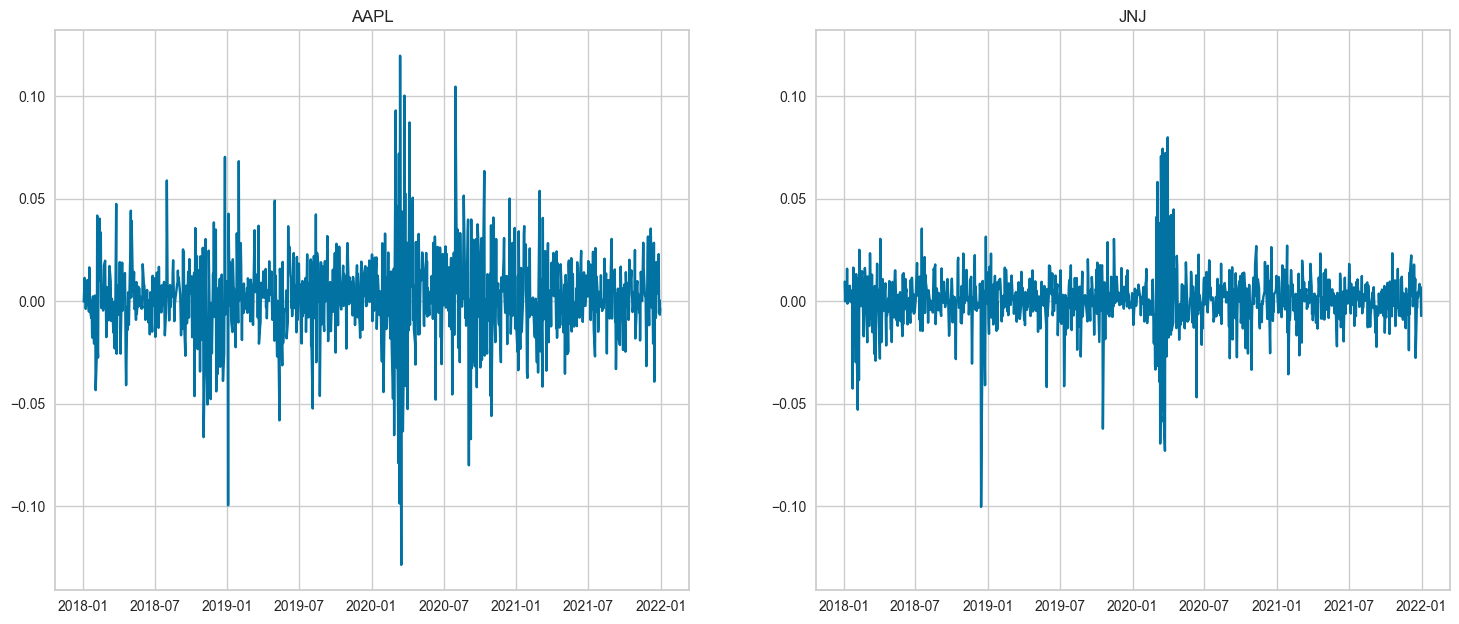

In [223]:
# Compare the movement of different stocks. 

plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(returns_1_day["AAPL"])
plt.title("AAPL")

plt.subplot(222, sharey=ax1)
plt.plot(returns_1_day["JNJ"])
plt.title("JNJ")
plt.show()

In [224]:
ret_T = returns_1_day.T

ret_T = pd.DataFrame(ret_T)
# ret_T.index = ret_T["Stock"]
ret_T.index.name = 'stock'
ret_T
# ret_T.rename(columns={"index":"Stock"},inplace=True)

date,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
stock,,,,,,,,,,,,,,,,,,,,,
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011653,...,0.004111,-0.006604,0.023534,0.018317,0.006506,0.005957,0.002772,0.009235,0.001432,-0.007646
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,0.026029,0.020649,0.047399,0.007726,0.000000,-0.004929,0.020363,-0.026429,0.001108,-0.006087
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000114,-0.000230,0.005680,0.010326,-0.005082,0.016516,...,-0.006502,-0.008122,0.019087,0.015319,0.003644,0.022975,-0.005767,0.000502,-0.006578,-0.003535
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007539,-0.005487,0.002930,0.010779,0.021427,0.018246,...,-0.017074,0.010268,-0.006954,0.016160,0.007876,0.009918,-0.000149,0.007218,0.004211,-0.003899
ABT,0.002211,-0.001697,0.002890,-0.002882,0.001700,-0.001527,0.006832,-0.001866,-0.006798,0.009411,...,0.007495,-0.015535,0.002149,0.027500,0.001223,0.016528,-0.006998,0.005125,-0.001346,-0.001844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.000858,0.010180,0.005828,0.001690,-0.002651,-0.002537,-0.000727,0.013699,-0.008252,0.001929,...,-0.012426,-0.002729,0.013681,0.009447,0.005274,0.019728,-0.000217,0.004928,-0.001947,0.003396
ZBH,0.006932,-0.001441,0.009941,0.001905,-0.016083,-0.013367,-0.001959,-0.001554,-0.003440,0.006657,...,0.003154,-0.016218,0.030028,0.018537,0.018119,0.008363,0.003130,0.000156,0.000312,-0.009589
ZBRA,0.019863,0.019760,0.015576,0.009951,0.030643,0.006666,0.055672,0.016341,0.001868,0.003242,...,-0.005945,-0.030143,0.016521,0.000379,0.003411,0.041071,-0.014860,0.006362,-0.005956,-0.003916


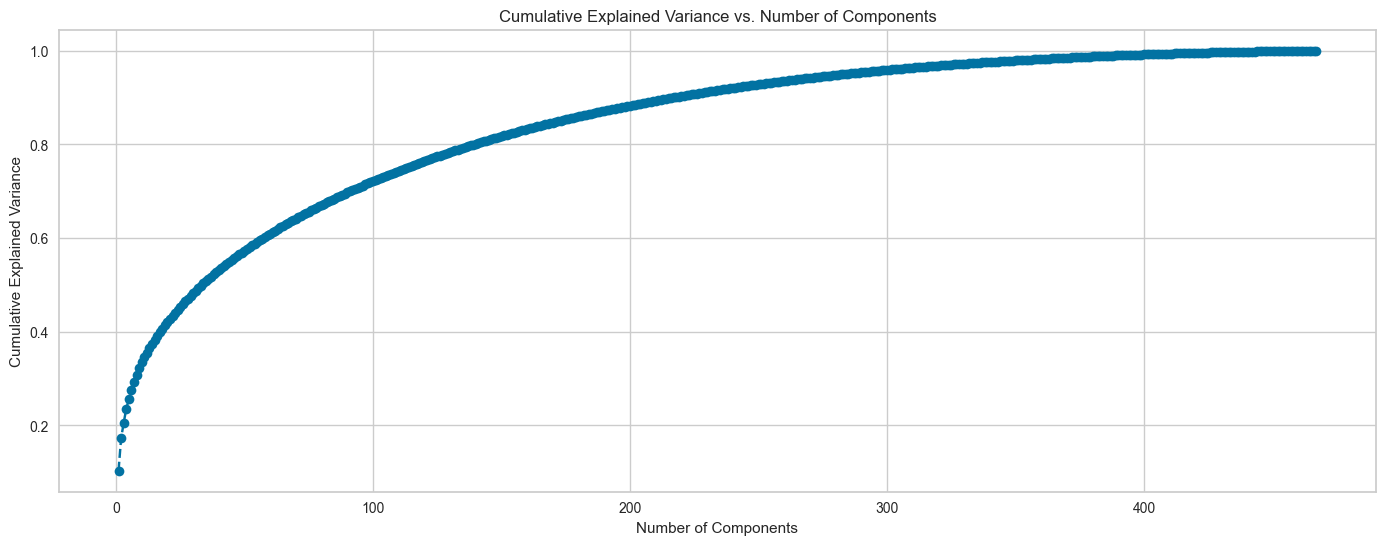

In [225]:
# Standardize the Data improve the robustness and performance of your models 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ret_T)

# PCA Dimensionality Reduction
pca = PCA(random_state=42)
pca.fit(scaled_data)

# Plot explained variance ratio to decide on the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(17, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [226]:
# Check the number of components needed to explain 80% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.8:
        print(str(i) + " components needed to explain 80% of the variance")
        break

# Check the number of components needed to explain 90% of the variance
for i in range(len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] > 0.9:
        print(str(i) + " components needed to explain 90% of the variance")
        break

139 components needed to explain 80% of the variance
216 components needed to explain 90% of the variance


In [240]:
scaled_data

array([[ 1.46883574, -0.68783477,  1.01584659, ...,  0.72028159,
         0.40006113, -1.14998587],
       [-1.36185312,  0.22715663, -0.59199198, ..., -3.39760422,
         0.36170948, -0.93319541],
       [-0.45413313,  0.11713667,  0.5636947 , ..., -0.28803165,
        -0.54843538, -0.57808685],
       ...,
       [ 1.04991668,  1.11888231,  0.97533015, ...,  0.38855166,
        -0.47470586, -0.63105742],
       [-0.52991805,  0.08416352, -0.51609283, ...,  0.27605936,
        -0.36669054, -0.02006571],
       [-0.09594178,  0.20457893,  0.56941842, ...,  0.96818018,
        -0.6658639 , -0.72751654]])

In [227]:
# Choose the number of components based on the plot
n_components = 139

pca = PCA(n_components=n_components, random_state=42)
principal_components = pca.fit_transform(scaled_data)

# principal_components as a dataframe
principal_components = pd.DataFrame(principal_components)
principal_components


,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,-5.479211,7.704879,-1.967459,-2.585308,-3.138361,1.005071,-0.262880,1.430286,-2.894413,-3.972031,...,0.390442,0.749587,-0.610886,0.747524,-1.335235,0.325837,1.058231,-1.093457,-0.057641,0.046098
1,24.897756,-3.252153,23.359524,1.585974,-2.790016,-3.909838,-0.920662,11.881755,-2.716606,9.330385,...,1.966087,0.196619,0.990921,0.485684,-2.084705,2.000147,-2.981106,2.190575,-2.008063,-1.453330
2,-5.068446,13.247532,0.041413,1.075789,0.695288,-2.274723,0.040577,-0.315646,1.426607,1.929121,...,-0.067255,-0.764661,-2.173866,0.199200,1.060600,1.164774,0.729434,-0.082496,-0.021722,1.632379
3,-6.292280,0.037114,-6.373048,-1.437888,-4.282348,-0.310420,2.050318,6.589692,0.978586,-2.067846,...,-1.623469,-0.362904,0.809433,-1.026808,-1.936460,-1.355343,-0.418973,-4.452547,0.679158,-0.438873
4,-10.259502,4.694771,-3.582877,-2.274708,-4.864646,0.425452,1.741851,3.222393,-1.349047,-3.114026,...,0.172811,-0.473593,1.362272,-0.786759,-0.294631,0.798019,-0.160386,0.246660,1.841936,1.136655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,-5.891133,-3.133561,2.432371,0.965394,-1.333445,0.498206,-1.827621,-2.058117,-0.839667,1.296167,...,2.286115,-0.399237,-0.419227,0.812650,-0.175669,0.958653,-0.712977,0.337457,-0.711314,-0.642428
463,-2.171109,-0.745387,2.027717,2.136059,-4.717494,-0.221523,0.201831,3.182292,-2.106576,-5.194903,...,-1.146441,1.232056,1.016058,-2.006836,1.885510,0.152255,-1.835318,-0.600521,-0.132143,1.693601
464,1.680518,13.496298,-0.307426,-0.257602,1.087085,0.567593,-4.559192,-1.480798,-0.707465,-1.479820,...,-1.308226,1.213015,-0.016103,2.013432,3.171589,-2.268792,-0.199598,-1.255339,0.205249,1.344634
465,17.452689,-7.949020,0.728821,-7.067059,-3.194552,4.133166,10.343921,-4.576144,6.570533,-0.383047,...,-0.259994,-0.219287,-0.279609,-0.515344,-0.523572,1.324707,-0.728312,-0.996415,-0.637162,-1.016658


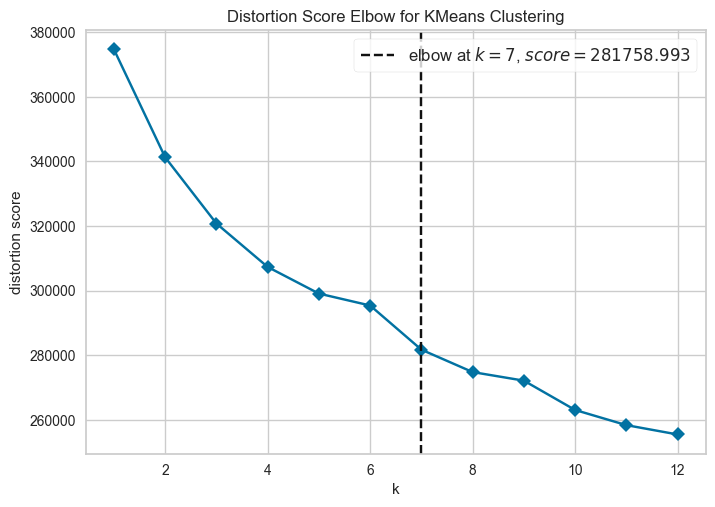

In [228]:
# Create k-Means model and find optimal number of clusters with the elbow method

model = KMeans(random_state = 42)
visualizer = KElbowVisualizer(
    model, k=(1,13), timings=False, random_state = 42
)

visualizer.fit(principal_components)        
visualizer.show()
n_clusters = visualizer.elbow_value_

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(principal_components)

In [229]:
# Add the cluster assignments to a copy of the returns dataframe

returns_clustered = ret_T.copy()
returns_clustered['Cluster'] = cluster_assignments

# Explore Clusters
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = returns_clustered[returns_clustered['Cluster'] == cluster_id].drop(columns=['Cluster'])
    mean_returns = cluster_stocks.mean(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())




# Additional Steps:
# - Choose pairs from the identified clusters for pairs trading
# - Develop and back-test the pairs trading strategy
# - Analyze and evaluate the performance of the strategy


Cluster 1 Mean Returns:
Total Mean Return: 0.0006673122266435481
Size: 138 Stocks
stock
ODFL    0.001585
HCA     0.001372
FCX     0.001347
LOW     0.001338
TT      0.001312
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.0006151246095558809
Size: 79 Stocks
stock
EXR    0.001239
PLD    0.001227
AES    0.001197
MAA    0.001117
KDP    0.001103
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: 0.0009377393935301118
Size: 127 Stocks
stock
DXCM    0.002670
CMG     0.002059
MSCI    0.001835
MOH     0.001728
WST     0.001721
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.005561716234221228
Size: 1 Stocks
stock
ENPH    0.005562
dtype: float64

Cluster 5 Mean Returns:
Total Mean Return: 0.0005484926606229634
Size: 54 Stocks
stock
CZR    0.002211
LYV    0.001459
AMP    0.001013
MS     0.000991
MGM    0.000971
dtype: float64

Cluster 6 Mean Returns:
Total Mean Return: 0.0015780595125728103
Size: 51 Stocks
stock
TSLA    0.003623
AMD     0.003165
ETSY    0.003050

In [230]:
n_clusters 

7

In [234]:
# Create and fit the model with the optimal number of clusters from above
model = KMeans(n_clusters = n_clusters)
model.fit(ret_T)

labels = model.predict(ret_T)

# create a DataFrame aligning labels & companies
clusters = pd.DataFrame({'cluster': labels, 'ticker': returns_1_day.columns})

for i in clusters.index:
    clusters.loc[i,"company"] = companies_dict[clusters.loc[i,"ticker"]]

# display df sorted by cluster labels. Would you say that the clustering makes sense?
clusters.sort_values('cluster').reset_index(drop=True)
# clusters.to_csv('clusters.csv')

,cluster,ticker,company
0,0,ZTS,Zoetis
1,0,NI,NiSource
2,0,NEM,Newmont
3,0,NEE,NextEra Energy
4,0,CVS,CVS Health
...,...,...,...
462,6,COF,Capital One
463,6,SYY,Sysco
464,6,KEY,KeyCorp
465,6,TXT,Textron


In [238]:
# Explore the clusters to identify potential pairs

for cluster_id in range(n_clusters):
    cluster_stocks = ret_T[ret_T.index.isin(clusters[clusters['cluster']==cluster_id]['ticker'])]
    mean_returns = cluster_stocks.mean(axis=1)
    volatility = cluster_stocks.std(axis=1)
    print(f'\nCluster {cluster_id + 1} Mean Returns:')
    print(f'Total Mean Return: {mean_returns.mean()}')
    print(f'Mean Volatility: {volatility.mean()}')
    print(f'Size: {mean_returns.count()} Stocks')
    print(mean_returns.sort_values(ascending=False).head())


Cluster 1 Mean Returns:
Total Mean Return: 0.0007354946514617044
Mean Volatility: 0.017278961689729387
Size: 119 Stocks
stock
WST     0.001721
POOL    0.001691
TGT     0.001508
LLY     0.001439
DHR     0.001405
dtype: float64

Cluster 2 Mean Returns:
Total Mean Return: 0.0005275576689189147
Mean Volatility: 0.03423998359459667
Size: 16 Stocks
stock
HES    0.001063
DVN    0.000966
OKE    0.000914
MRO    0.000800
COP    0.000785
dtype: float64

Cluster 3 Mean Returns:
Total Mean Return: 0.0007458904780608229
Mean Volatility: 0.0204633295474031
Size: 93 Stocks
stock
ODFL    0.001585
CPRT    0.001431
STX     0.001429
LOW     0.001338
TT      0.001312
dtype: float64

Cluster 4 Mean Returns:
Total Mean Return: 0.0015771887079352224
Mean Volatility: 0.025236071370952875
Size: 67 Stocks
stock
ENPH    0.005562
TSLA    0.003623
AMD     0.003165
ETSY    0.003050
SEDG    0.002822
dtype: float64

Cluster 5 Mean Returns:
Total Mean Return: 0.0007418556468875217
Mean Volatility: 0.020252145088223115

In [233]:
clusters.groupby("cluster").count()

,ticker,company
cluster,,
0,154,154
1,66,66
2,6,6
3,137,137
4,16,16
5,28,28
6,60,60


In [ ]:
# Perform T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform()